### Question 4.1

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pydot
# !conda install --yes --prefix {sys.prefix} graphviz


In [15]:
from collections import Counter

import numpy as np
import pandas as pd
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pydot import graph_from_dot_data
from matplotlib import pyplot as plt
import io

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number

In [3]:
class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None, randomForest = False, maxFeatures = None):
        self.max_depth = max_depth
        self.maxFeatures = maxFeatures
        self.randomForest = randomForest
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.labels = None # for leaf nodes
        self.pure = False # for leaf nodes
        self.unsplittable = False # for leaf nodes

    @staticmethod
    def entropy(y):
        """ Given a set of labels, find the entropy within."""
        unique, counts = np.unique(y, return_counts=True)
        freq = dict(zip(unique, counts))
        result = 0
        for c in freq.keys():
            pc = freq[c]/len(y)
            result += pc * np.log2(pc)
        return -result

    def information_gain(self, X, y, idx, thresh):
        """ Given a feature index (idx), and the threshold, we split
            and find the information gain from that split."""
        
        X0, y0, X1, y1 = self.split(X, y, idx, thresh)
        Hs = DecisionTree.entropy(y)
        Hafter = (len(y0)*DecisionTree.entropy(y0) + len(y1)*DecisionTree.entropy(y1))
        Hafter = Hafter/(len(y0) + len(y1))
        return Hs - Hafter

    @staticmethod
    def gini_impurity(y):
        #Calculate impurity for a set of rows
        impurity = 1
        unique, counts = np.unique(y, return_counts=True)
        freq = dict(zip(unique, counts))
        for label in freq:
            pc = freq[label]/len(y)
            impurity -= pc**2
        return impurity
    
    def gini_purification(self, X, y, idx, thresh):
        X0, y0, X1, y1 = self.split(X, y, idx, thresh)
        p = float(len(y0)) / (len(y0) + len(y1))
        return DecisionTree.gini_impurity(y) - p * DecisionTree.gini_impurity(y0) - (1 - p) * DecisionTree.gini_impurity(y1)

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y, gain = 'gini'):
        """ Find the feature and threshold that gives the best increase in
            information gain. Split, then recursively call on children. Currently uses entropy."""

        #If doing random forest, take random sample of X.
        if self.randomForest:
            xTrue = X
            #Select random sample of features
            idx = np.random.choice(X.shape[1], size=self.maxFeatures, replace=False)
            X = np.array([X[i][idx] for i in range(X.shape[0])])
            
        #First check if y is all in 1 class
        if np.all(y == y[0]):
            self.data, self.labels, self.pred = X, y, y[0]
            self.pure = True
            return self
        
        #If they have same labels but different classes, take most likely class
        if np.all(X == X[0]) or self.max_depth == 0:
            mostLikely, _ = stats.mode(y)
            self.data, self.labels, self.pred = X, y, mostLikely
            if np.all(X == X[0]):
                self.unsplittable = True
            return self

        bestGain = 0
        bestIdx = None
        bestThresh = None
        nFeatures = len(X[0])

        for featureIdx in range(nFeatures):
            vals = set([sample[featureIdx] for sample in X])

            for thresh in vals:
                if gain == 'entropy':
                    currGain = self.information_gain(X, y, featureIdx, thresh)
                elif gain == 'gini':
                    currGain = self.gini_purification(X, y, featureIdx, thresh)
                
                X0, y0, X1, y1 = self.split(X, y, featureIdx, thresh)

                #If the current made a empty side
                if len(y0) == 0 or len(y1) == 0:
                    continue
            
                if currGain >= bestGain:
                    bestIdx = featureIdx
                    bestThresh = thresh
                    bestGain = currGain
        
        #If we cant gain without splitting all data on one side or the other, it is unsplittable
        if bestIdx == None:
            mostLikely, _ = stats.mode(y)
            self.data, self.labels, self.pred = X, y, mostLikely

            self.unsplittable = True
            return self           

        #Split on best index and feature
        self.split_idx = bestIdx
        self.thresh = bestThresh
        
        if self.thresh == None:
            print(self.split_idx, self.thresh)
            print("Best Gain: ", bestGain)
            print("X: \n", X)
            print("Y: \n", y)

        #If splitting using random forest, restore old X.
        if self.randomForest:
            self.split_idx = idx[bestIdx]
            X = xTrue
        else:
            self.split_idx = bestIdx
        self.thresh = bestThresh
        
        X0, y0, X1, y1 = self.split(X, y, self.split_idx, self.thresh)

        #After figuring out this data, we can now set it for this treenode
        self.left = DecisionTree(max_depth = self.max_depth - 1, feature_labels=self.features)
        self.left = self.left.fit(X0, y0)
        self.right = DecisionTree(max_depth = self.max_depth - 1, feature_labels=self.features)
        self.right = self.right.fit(X1, y1)
        
        return self
    
    def predict(self, X):
        if self.pred != None:
            return self.pred    
        if X[self.split_idx] < self.thresh:
            return self.left.predict(X)
        else:
            return self.right.predict(X)
        
    # def predictSet(self, X):
    #     preds = []
    #     for sample in X:
    #         preds.append(self.predictSample(sample))
    #     return preds
        
    # def predictSample(self, X):
    #     if self.pred != None:
    #         return self.pred
        
    #     if X[self.split_idx] < self.thresh:
    #         return self.left.predictSample(X)
    #     else:
    #         return self.right.predictSample(X)
        
    def __repr__(self):
        if self.max_depth == 0 or self.pure == True or self.unsplittable == True:
            return "%s (%s)" % (self.pred, self.data.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

In [4]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False
    
    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # print("OneHot Features:\n", onehot_features)
    # print("OneHot Encoding:\n", onehot_encoding)
    # print("Data after -1 (First 10):\n", data[:10])
    # print("Data shape: ", data.shape)

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        modeList = []
        for col in range(len(data[0])):
            column = [val for val in data[:, col] if val != -1]
            # mode, _ = stats.mode(column, keepdims=False)
            # modeList.append(mode)
            modeList.append(np.average(column))

        # print(modeList)
        noDataIdx = np.where(data == -1)
        noDataIdx = zip(noDataIdx[0], noDataIdx[1])
        noDataIdx = list(noDataIdx)
        # print(noDataIdx)
        for (x, y) in noDataIdx:
            # print(x, y, modeList[y])
            data[x][y] = modeList[y]

        
        # print("Data after fill: \n", data[:10])
        

    # print("Data: ", data)
    # print("One hot: ",onehot_features)
    return data, onehot_features


def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)

In [5]:
# dataset = "titanic"
dataset = "spam"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100

if dataset == "titanic":
    # Load titanic data
    path_train = 'datasets/titanic/titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None)
    path_test = 'datasets/titanic/titanic_testing_data.csv'
    test_data = genfromtxt(path_test, delimiter=',', dtype=None)
    y = data[1:, 0]  # label = survived
    class_names = ["Died", "Survived"]

    # print(data.shape)
    # print(data[:, 1:][0:10])

    labeled_idx = np.where(y != b'')[0]
    y = np.array(y[labeled_idx], dtype=float).astype(int)
    print("\n\nPart (b): preprocessing the titanic dataset")
    X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]

    #Split into training and validation set
    xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True)
    print("Train/Val size", xTrain.shape, xVal.shape)

    Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z.shape[1]
    features = list(data[0, 1:]) + onehot_features
    # print(features)
elif dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = 'datasets/spam_data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

    #Split into training and validation set
    xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.2, random_state=88, shuffle=True)
    print("Train/Val size", xTrain.shape, xVal.shape)
    
else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print("Features", features)
print("Train/test size", X.shape, Z.shape)
# print(X[0:15])


Train/Val size (4503, 32) (1126, 32)
Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5629, 32) (5400, 32)


In [6]:
print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - np.sum(y) / y.size)



Part 0: constant classifier
Accuracy 0.7258838159531


In [7]:
def accuracy(preds, yDataSet):
    result = 0
    for idx in range(len(preds)):
        if preds[idx] == yDataSet[idx]:
            result += 1
    result = result / len(preds)
    return result

def validate(model, xDataSet, yDataSet):
    preds = []
    for sample in xDataSet:
        preds.append(model.predict(sample))
    return accuracy(preds, yDataSet), preds

In [8]:
giniTree = DecisionTree(max_depth = 12, feature_labels=features)
giniTree.fit(xTrain, yTrain, gain='gini')

[exclamation < 1.0: [parenthesis < 1.0: [creative < 1.0: [money < 1.0: [pain < 1.0: [meter < 1.0: [dollar < 1.0: [prescription < 1.0: [ampersand < 1.0: [spam < 1.0: [private < 1.0: [other < 1.0: 0.0 (37056) | 0.0 (2528)] | [business < 1.0: 1.0 (384) | 0.0 (64)]] | 1.0 (160)] | [out < 2.0: [semicolon < 1.0: [message < 1.0: 0.0 (3648) | 0.0 (160)] | [other < 1.0: 0.0 (160) | 1.0 (32)]] | [square_bracket < 1.0: 0.0 (128) | 1.0 (32)]]] | 1.0 (256)] | [energy < 1.0: [volumes < 1.0: [dollar < 2.0: [ampersand < 1.0: [sharp < 1.0: 1.0 (1536) | 0.0 (96)] | 0.0 (96)] | [dollar < 54.0: [dollar < 9.0: 1.0 (1472) | 1.0 (160)] | 0.0 (64)]] | 0.0 (192)] | 0.0 (448)]] | 0.0 (4800)] | [pain < 2.0: [out < 1.0: [message < 1.0: [other < 1.0: [differ < 1.0: 1.0 (288) | 1.0 (32)] | 1.0 (32)] | 1.0 (32)] | 1.0 (32)] | 1.0 (96)]] | [business < 1.0: [energy < 1.0: [semicolon < 2.0: [sharp < 1.0: [semicolon < 1.0: [out < 1.0: [message < 1.0: [dollar < 1.0: 0.0 (224) | 0.0 (256)] | 1.0 (32)] | 1.0 (64)] | 1.0 (6

In [9]:
validate(giniTree, xVal, yVal)[0]

0.8303730017761989

In [10]:
entTree = DecisionTree(max_depth = 12, feature_labels=features)
entTree.fit(xTrain, yTrain, gain='entropy')

[exclamation < 1.0: [parenthesis < 1.0: [creative < 1.0: [money < 1.0: [pain < 1.0: [meter < 1.0: [dollar < 1.0: [prescription < 1.0: [ampersand < 1.0: [spam < 1.0: [private < 1.0: [other < 1.0: 0.0 (37056) | 0.0 (2528)] | [business < 1.0: 1.0 (384) | 0.0 (64)]] | 1.0 (160)] | [out < 2.0: [semicolon < 1.0: [message < 1.0: 0.0 (3648) | 0.0 (160)] | [other < 1.0: 0.0 (160) | 1.0 (32)]] | [square_bracket < 1.0: 0.0 (128) | 1.0 (32)]]] | 1.0 (256)] | [energy < 1.0: [volumes < 1.0: [dollar < 2.0: [ampersand < 1.0: [sharp < 1.0: 1.0 (1536) | 0.0 (96)] | 0.0 (96)] | [dollar < 54.0: [dollar < 9.0: 1.0 (1472) | 1.0 (160)] | 0.0 (64)]] | 0.0 (192)] | 0.0 (448)]] | 0.0 (4800)] | [pain < 2.0: [out < 1.0: [message < 1.0: [other < 1.0: [differ < 1.0: 1.0 (288) | 1.0 (32)] | 1.0 (32)] | 1.0 (32)] | 1.0 (32)] | 1.0 (96)]] | [business < 1.0: [energy < 1.0: [semicolon < 2.0: [sharp < 1.0: [semicolon < 1.0: [out < 1.0: [message < 1.0: [dollar < 1.0: 0.0 (224) | 0.0 (256)] | 1.0 (32)] | 1.0 (64)] | 1.0 (6

In [11]:
validate(entTree, xTrain, yTrain)[0]

0.8687541638907396

In [12]:
validate(entTree, xVal, yVal)[0]

0.8303730017761989

In [127]:
# sklearn decision tree
print("\n\nsklearn's decision tree")
clf = DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf)
out = io.StringIO()
export_graphviz(
    clf, out_file=out, feature_names=features, class_names=class_names)
# For OSX, may need the following for dot: brew install gprof2dot
graph = graph_from_dot_data(out.getvalue())
graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)



sklearn's decision tree
Cross validation [0.81188119 0.7970297  0.76732673 0.77227723 0.78606965]


### 4.2

In [56]:
class BaggedTrees:

    # def __init__(self, max_depth, feature_labels, subsetSize, numTrees=200):
    def __init__(self, params=None, subsetSize=100, numTrees=200):
        if params is None:
            params = {}
        self.params = params
        # self.max_depth = max_depth
        # self.features= feature_labels
        self.n = numTrees
        self.subsetSize = subsetSize
        self.decision_trees = [
            DecisionTree(**self.params)
            for i in range(self.n)
        ]

    def bagFit(self, X, y):
        #Make n subsets of data
        xSubset = []
        ySubset = []
        for _ in range(self.n):
            idx = np.random.choice(X.shape[0], size=self.subsetSize, replace=True)
            xSubset.append(X[idx])
            ySubset.append(y[idx])
        # print("xSubset: ", xSubset[0])
        # print("ySubset: ", ySubset[0].shape)

        for i in range(len(self.decision_trees)):
            self.decision_trees[i].fit(xSubset[i], ySubset[i])
        return self

    def predict(self, X):
        preds = []
        for i in range(len(self.decision_trees)):
            preds.append(self.decision_trees[i].predict(X))
        return round(np.average(preds))
        

class RandomForest(BaggedTrees):

    def __init__(self, params=None, maxFeatures=10, subsetSize=100, numTrees=200):
        if params is None:
            params = {}
        super().__init__(params, subsetSize, numTrees)

In [82]:
result = []
for subsetSize in np.arange(90, 110, step=2):
    for trees in np.arange(20, 100, step=20):
        params = {'max_depth':3, 'feature_labels':features}
        bagTree = BaggedTrees(params, subsetSize, trees)
        bagTree.bagFit(xTrain, yTrain)
        preds = []
        for sample in xVal:
            preds.append(bagTree.bagPredict(sample))
        result.append((subsetSize, trees, accuracy(preds)))

In [114]:
result.sort(key= lambda x: x[2], reverse=True)

In [115]:
result[:10]

[(94, 60, 0.8134991119005328),
 (106, 80, 0.8126110124333925),
 (100, 20, 0.8117229129662522),
 (98, 40, 0.8108348134991119),
 (108, 80, 0.8099467140319716),
 (92, 60, 0.8081705150976909),
 (108, 40, 0.8081705150976909),
 (92, 20, 0.80550621669627),
 (100, 60, 0.80550621669627),
 (104, 60, 0.80550621669627)]

In [38]:
#(50, 100, 12, 0.8259325044404974)
params = {'max_depth':12, 'feature_labels':features}
bagTree = BaggedTrees(params, 50, 100)
bagTree.bagFit(xTrain, yTrain)


In [39]:
validate(bagTree)

0.8090586145648313

In [57]:

params = {'max_depth':3, 'feature_labels':features, 'randomForest':True, 'maxFeatures':round(np.sqrt(xTrain.shape[1]))}
randForest = RandomForest(params, subsetSize=98, numTrees=60)
randForest.bagFit(xTrain, yTrain)

In [27]:
validate(randForest)

0.8037300177619894

In [49]:
np.sqrt(subsetSize)

7.0710678118654755

In [167]:
result = []
for subsetSize in [50, 100, 150]: #np.arange(90, 110, step=2):
    for trees in [100, 150, 200]: #np.arange(20, 100, step=20):
        for maxDepth in [3, 6, 12]: #np.arange(20, 100, step=20):
            params = {'max_depth':maxDepth, 'feature_labels':features, 'randomForest':True, 'maxFeatures': round(np.sqrt(subsetSize))}
            randForest = RandomForest(params, subsetSize, trees)
            randForest.bagFit(xTrain, yTrain)
            preds = []
            for sample in xVal:
                preds.append(randForest.predict(sample))
            result.append((subsetSize, trees, maxDepth, accuracy(preds, yVal)))

In [168]:
result.sort(key= lambda x: x[3], reverse=True)

In [169]:
result

[(50, 150, 3, 0.7970297029702971),
 (100, 200, 12, 0.7970297029702971),
 (150, 150, 3, 0.7970297029702971),
 (50, 150, 12, 0.7920792079207921),
 (50, 200, 12, 0.7920792079207921),
 (100, 150, 3, 0.7920792079207921),
 (100, 200, 3, 0.7920792079207921),
 (100, 200, 6, 0.7920792079207921),
 (50, 100, 6, 0.7871287128712872),
 (150, 100, 6, 0.7871287128712872),
 (150, 100, 12, 0.7871287128712872),
 (150, 200, 3, 0.7871287128712872),
 (150, 200, 12, 0.7871287128712872),
 (50, 200, 3, 0.7821782178217822),
 (100, 100, 6, 0.7821782178217822),
 (100, 150, 12, 0.7821782178217822),
 (150, 150, 6, 0.7821782178217822),
 (150, 150, 12, 0.7821782178217822),
 (150, 200, 6, 0.7821782178217822),
 (50, 100, 3, 0.7772277227722773),
 (50, 100, 12, 0.7772277227722773),
 (50, 150, 6, 0.7772277227722773),
 (100, 100, 12, 0.7772277227722773),
 (50, 200, 6, 0.7722772277227723),
 (100, 100, 3, 0.7722772277227723),
 (100, 150, 6, 0.7722772277227723),
 (150, 100, 3, 0.7673267326732673)]

In [170]:
#Random Tree Spam: (100, 150, 12, 0.8285968028419183)
#Titanic: (50, 150, 3, 0.7970297029702971)
params = {'max_depth':3, 'feature_labels':features, 'randomForest':True, 'maxFeatures':round(np.sqrt(xTrain.shape[1]))}
randForest = RandomForest(params, subsetSize=20, numTrees=150)
randForest.bagFit(xTrain, yTrain)

In [178]:
validate(randForest, xTrain, yTrain)[0]

0.79182156133829

In [179]:
validate(randForest, xVal, yVal)[0]

0.7970297029702971

In [174]:
Z.shape

(300, 14)

In [52]:
#Kaggle Submissions
preds = []
for sample in Z:
    preds.append(giniTree.predict(sample))

id = [*range(1, len(Z)+1)]
outputDict = {"Id":id, "Category": preds}
df = pd.DataFrame(outputDict)
df.to_csv('titanicResult2.csv', index=False)

In [26]:
score = []
for depth in range(2, 42, 2):
    giniTree = DecisionTree(max_depth = depth, feature_labels=features)
    giniTree.fit(xTrain, yTrain, gain='gini')
    score.append(validate(giniTree, xVal, yVal)[0])

Text(0.5, 1.0, 'Depth and Val Score for Spam')

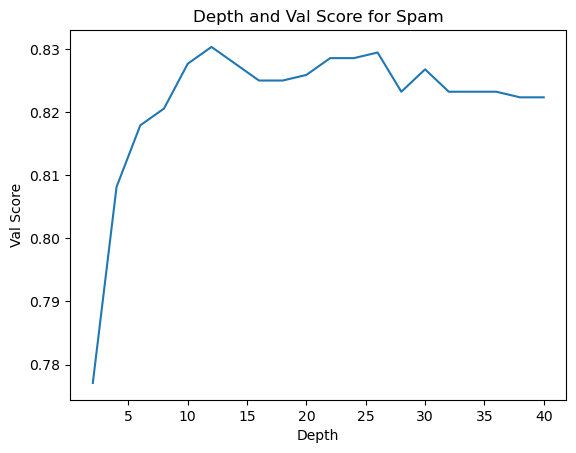

In [29]:
depth = []
depth.extend(range(2, 42, 2))
plt.plot(depth, score)
plt.xlabel("Depth")
plt.ylabel("Val Score")
plt.title("Depth and Val Score for Spam")